<a href="https://colab.research.google.com/github/Yaron-Grushka/music-genre-classification/blob/main/Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uploading the DATA to Colab

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()


In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                       title                                         size  lastUpdated          downloadCount  
--------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  
michau96/restaurant-business-rankings-2020                Restaurant Business Rankings 2020             16KB  2021-01-30 14:20:45           3673  
gpreda/reddit-wallstreetsbets-posts                       Reddit WallStreetBets Posts                    8MB  2021-02-26 11:18:15           1828  
yorkehead/stock-market-subreddits                         Stock Market Subreddits                        1MB  2021-01-29 13:53:50            362  
aagghh/crypto-telegram-groups                             Crypto telegram groups                       297MB  2021-02-02 09:58:25            214  
timoboz/superbowl-history-1967-2020                       

In [4]:
! kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

gtzan-dataset-music-genre-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
! mkdir dataset-music-genre 
! unzip gtzan-dataset-music-genre-classification.zip -d dataset-music-genre



mkdir: cannot create directory ‘dataset-music-genre’: File exists
Archive:  gtzan-dataset-music-genre-classification.zip
replace dataset-music-genre/Data/features_30_sec.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: dataset-music-genre/Data/features_30_sec.csv  
  inflating: dataset-music-genre/Data/features_3_sec.csv  
  inflating: dataset-music-genre/Data/genres_original/blues/blues.00000.wav  
  inflating: dataset-music-genre/Data/genres_original/blues/blues.00001.wav  
  inflating: dataset-music-genre/Data/genres_original/blues/blues.00002.wav  
  inflating: dataset-music-genre/Data/genres_original/blues/blues.00003.wav  
  inflating: dataset-music-genre/Data/genres_original/blues/blues.00004.wav  
  inflating: dataset-music-genre/Data/genres_original/blues/blues.00005.wav  
  inflating: dataset-music-genre/Data/genres_original/blues/blues.00006.wav  
  inflating: dataset-music-genre/Data/genres_original/blues/blues.00007.wav  
  inflating: dataset-music-genre/Data/genr

# Code

In [6]:

from __future__ import print_function, division
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import torch.nn as nn
from PIL import Image
import torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import copy
import torch.nn.functional as F
import requests
import torchvision.models as vision_models


In [7]:
data_dir='dataset-music-genre/Data/images_original/'
BATCH_SIZE = 8

transform = transforms.Compose([transforms.Resize(244),
                                transforms.CenterCrop(244),                              
                                transforms.ToTensor()])

dataset = datasets.ImageFolder(data_dir, transform=transform)


trainset ,testset = torch.utils.data.random_split(dataset,[800,199], generator=torch.Generator().manual_seed(42))


trainloader =  torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE)

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
def test_loss(net, criterion, test_loss_history):
  running_loss = 0.0
  with torch.no_grad():
    for data in testloader:
      inputs, labels = data
      inputs = inputs.cuda() # -- For GPU
      labels = labels.cuda() # -- For GPU
      output = net(inputs)
      loss = criterion(output, labels)
      running_loss += loss.item()
    test_loss_history.append(running_loss/len(testloader))


def train_network(net, EPOCHS):
  criterion = nn.CrossEntropyLoss()
  learning_rate=0.001
  optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
  train_loss_history = []
  test_loss_history = []
  
  for epoch in range(EPOCHS):
      correct = 0
      loss = 0
      net.train()
      for batch_idx, (X_batch, y_batch) in enumerate(trainloader):
          X_batch = X_batch.cuda()
          y_batch = y_batch.cuda()
          optimizer.zero_grad()
          output = net(X_batch)
          loss = criterion(output, y_batch)

          loss.backward()
          optimizer.step()

          # Total correct predictions
          predicted = torch.max(output.data, 1)[1] 
          correct += (predicted == y_batch).sum()
          if batch_idx % 50 == 0:
              print('Epoch : {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}\t Accuracy:{:.3f}%'.format(epoch, batch_idx*len(X_batch), len(trainloader.dataset), 100.*batch_idx / len(trainloader), loss.data, float(correct*100) / float(BATCH_SIZE*(batch_idx+1))))
      
      train_loss_history.append(loss)
      net.eval()
      test_loss(net, criterion, test_loss_history)

  return train_loss_history, test_loss_history


def plot_loss(train_loss_history, test_loss_history, acc, description):
  # Plot the loss over the epochs
  plt.plot(np.arange(len(train_loss_history)) + 1, train_loss_history, color='b', label='Train') 
  plt.plot(np.arange(len(test_loss_history)) + 1, test_loss_history, color = 'r', label='Test')

  plt.title(f'Changes to model: {description}\nTest accuracy: {str(round(acc, 3))}%')
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend()

  path_to_save = '/content/drive/My Drive/net images/' + description
  plt.savefig(path_to_save)
  plt.show()

def calc_accuracy(net):
  print(net.eval())
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.cuda(), labels.cuda()
          outputs = net(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  acc = 100 * correct / total
  print('Accuracy of the network on the test images: %d %%' % (acc))
  return acc

In [ ]:
class CNN0(nn.Module):
    def __init__(self,original_model=None):
        super(CNN0, self).__init__()
        
        # Convolutional layers:
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        
        # Linear layers:
        self.fc1 = nn.Linear(476288, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
      # Convolutional layers:
      x = self.conv1(x)
      x = F.max_pool2d(F.relu(x), 2)
      x = self.conv2(x)
      x = F.max_pool2d(F.relu(x), 2)

      x = x.view(x.size(0), -1)
      # Linear layers:
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      
      return x

In [33]:
for i in [10, 20]:
  print('#' * 30)
  print(f'Epochs: {i}')
  print('#' * 30)
  net = CNN0().cuda()
  train_loss_history, test_loss_history = train_network(net, i)
  acc = calc_accuracy(net)
  plot_loss(train_loss_history, test_loss_history, acc, f'Basic model, {i} epochs')

##############################
Epochs: 10
##############################
Epoch : 0 [0/800 (0%)]	Loss: 2.299150	 Accuracy:12.500%
Epoch : 0 [400/800 (50%)]	Loss: 2.293015	 Accuracy:9.559%
Epoch : 1 [0/800 (0%)]	Loss: 2.299969	 Accuracy:0.000%
Epoch : 1 [400/800 (50%)]	Loss: 2.315017	 Accuracy:10.539%
Epoch : 2 [0/800 (0%)]	Loss: 2.298415	 Accuracy:0.000%
Epoch : 2 [400/800 (50%)]	Loss: 2.316142	 Accuracy:9.559%
Epoch : 3 [0/800 (0%)]	Loss: 2.295172	 Accuracy:12.500%
Epoch : 3 [400/800 (50%)]	Loss: 2.312632	 Accuracy:10.784%
Epoch : 4 [0/800 (0%)]	Loss: 2.298711	 Accuracy:12.500%
Epoch : 4 [400/800 (50%)]	Loss: 2.301354	 Accuracy:9.069%
Epoch : 5 [0/800 (0%)]	Loss: 2.298361	 Accuracy:12.500%
Epoch : 5 [400/800 (50%)]	Loss: 2.297448	 Accuracy:10.539%
Epoch : 6 [0/800 (0%)]	Loss: 2.302443	 Accuracy:0.000%
Epoch : 6 [400/800 (50%)]	Loss: 2.301785	 Accuracy:8.333%


KeyboardInterrupt: ignored

In [14]:
class CNN1(nn.Module):
    def __init__(self,original_model=None):
        super(CNN1, self).__init__()
        
        # Convolutional layers:
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        
        # Linear layers:
        self.fc1 = nn.Linear(4608, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
      # Convolutional layers:
      x = self.conv1(x)
      x = F.max_pool2d(F.relu(x), 2)
      x = self.conv2(x)
      x = F.max_pool2d(F.relu(x), 2)
      x = self.conv3(x)
      x = F.max_pool2d(F.relu(x), 4)
      x = self.conv4(x)
      x = F.max_pool2d(F.relu(x), 4)

      x = x.view(x.size(0), -1)

      # Linear layers:
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      
      return x
    

Epoch : 0 [0/800 (0%)]	Loss: 2.306717	 Accuracy:12.500%
Epoch : 0 [400/800 (50%)]	Loss: 2.287439	 Accuracy:8.578%
Epoch : 1 [0/800 (0%)]	Loss: 2.301823	 Accuracy:0.000%
Epoch : 1 [400/800 (50%)]	Loss: 2.222032	 Accuracy:14.216%
Epoch : 2 [0/800 (0%)]	Loss: 2.290824	 Accuracy:0.000%
Epoch : 2 [400/800 (50%)]	Loss: 2.266621	 Accuracy:8.824%
Epoch : 3 [0/800 (0%)]	Loss: 2.328974	 Accuracy:0.000%
Epoch : 3 [400/800 (50%)]	Loss: 2.300370	 Accuracy:12.255%
Epoch : 4 [0/800 (0%)]	Loss: 2.066357	 Accuracy:25.000%
Epoch : 4 [400/800 (50%)]	Loss: 2.132614	 Accuracy:17.647%
Epoch : 5 [0/800 (0%)]	Loss: 1.938559	 Accuracy:25.000%
Epoch : 5 [400/800 (50%)]	Loss: 2.197551	 Accuracy:20.833%
Epoch : 6 [0/800 (0%)]	Loss: 2.195888	 Accuracy:0.000%
Epoch : 6 [400/800 (50%)]	Loss: 1.477485	 Accuracy:21.814%
Epoch : 7 [0/800 (0%)]	Loss: 1.793609	 Accuracy:37.500%
Epoch : 7 [400/800 (50%)]	Loss: 1.904121	 Accuracy:24.755%
Epoch : 8 [0/800 (0%)]	Loss: 2.117855	 Accuracy:12.500%
Epoch : 8 [400/800 (50%)]	Loss

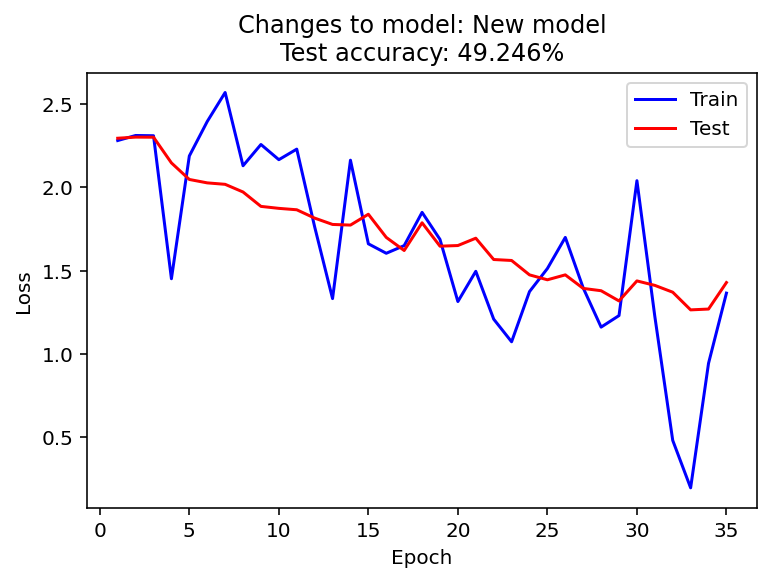

In [15]:
net = CNN1().cuda()
train_loss_history, test_loss_history = train_network(net, 35)
acc = calc_accuracy(net)
plot_loss(train_loss_history, test_loss_history, acc, 'New model')

In [34]:
class CNN2(nn.Module):
    def __init__(self,original_model=None):
        super(CNN2, self).__init__()
        
        # Convolutional layers:
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv3.weight)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv4.weight)
        
        # Linear layers:
        self.fc1 = nn.Linear(4608, 1024)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(1024, 256)
        torch.nn.init.xavier_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(256, 10)
        torch.nn.init.xavier_normal_(self.fc3.weight)

    def forward(self, x):
      # Convolutional layers:
      x = self.conv1(x)
      x = F.max_pool2d(F.relu(x), 2)
      x = self.conv2(x)
      x = F.max_pool2d(F.relu(x), 2)
      x = self.conv3(x)
      x = F.max_pool2d(F.relu(x), 4)
      x = self.conv4(x)
      x = F.max_pool2d(F.relu(x), 4)

      x = x.view(x.size(0), -1)

      # Linear layers:
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      
      return x

##############################
Epochs: 10
##############################
Epoch : 0 [0/800 (0%)]	Loss: 3.139032	 Accuracy:12.500%
Epoch : 0 [400/800 (50%)]	Loss: 2.248960	 Accuracy:12.500%
Epoch : 1 [0/800 (0%)]	Loss: 2.220100	 Accuracy:25.000%
Epoch : 1 [400/800 (50%)]	Loss: 2.053669	 Accuracy:17.647%
Epoch : 2 [0/800 (0%)]	Loss: 1.766377	 Accuracy:25.000%
Epoch : 2 [400/800 (50%)]	Loss: 2.621505	 Accuracy:25.980%
Epoch : 3 [0/800 (0%)]	Loss: 1.643453	 Accuracy:25.000%
Epoch : 3 [400/800 (50%)]	Loss: 2.099684	 Accuracy:23.529%
Epoch : 4 [0/800 (0%)]	Loss: 1.764467	 Accuracy:12.500%
Epoch : 4 [400/800 (50%)]	Loss: 1.574974	 Accuracy:32.843%
Epoch : 5 [0/800 (0%)]	Loss: 1.034691	 Accuracy:62.500%
Epoch : 5 [400/800 (50%)]	Loss: 2.303922	 Accuracy:41.176%
Epoch : 6 [0/800 (0%)]	Loss: 2.069479	 Accuracy:37.500%
Epoch : 6 [400/800 (50%)]	Loss: 1.951906	 Accuracy:49.265%
Epoch : 7 [0/800 (0%)]	Loss: 1.786068	 Accuracy:50.000%
Epoch : 7 [400/800 (50%)]	Loss: 1.353024	 Accuracy:54.902%
Epoch :

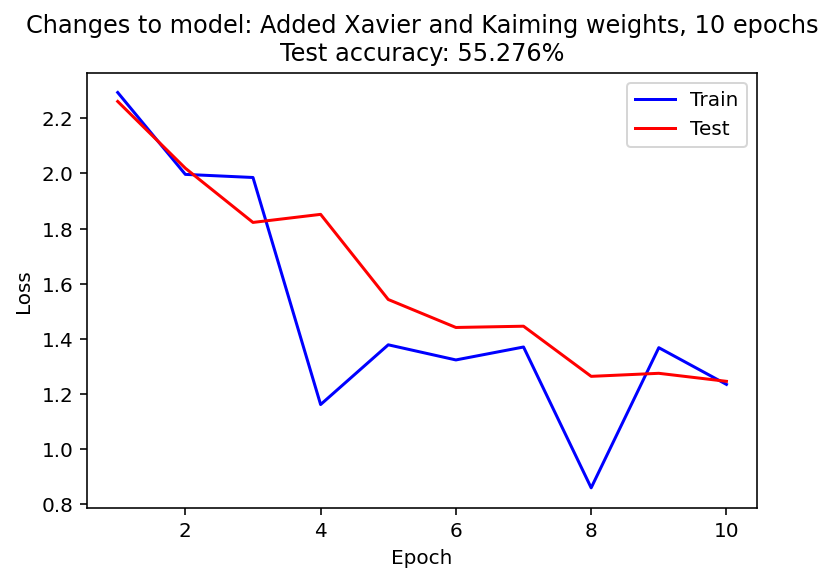

##############################
Epochs: 15
##############################
Epoch : 0 [0/800 (0%)]	Loss: 3.826029	 Accuracy:0.000%
Epoch : 0 [400/800 (50%)]	Loss: 2.000574	 Accuracy:12.010%
Epoch : 1 [0/800 (0%)]	Loss: 2.100979	 Accuracy:12.500%
Epoch : 1 [400/800 (50%)]	Loss: 1.941725	 Accuracy:19.118%
Epoch : 2 [0/800 (0%)]	Loss: 1.911004	 Accuracy:25.000%
Epoch : 2 [400/800 (50%)]	Loss: 1.771711	 Accuracy:27.696%
Epoch : 3 [0/800 (0%)]	Loss: 1.416665	 Accuracy:25.000%
Epoch : 3 [400/800 (50%)]	Loss: 0.916571	 Accuracy:38.971%
Epoch : 4 [0/800 (0%)]	Loss: 1.380635	 Accuracy:50.000%
Epoch : 4 [400/800 (50%)]	Loss: 2.164921	 Accuracy:43.137%
Epoch : 5 [0/800 (0%)]	Loss: 1.479216	 Accuracy:50.000%
Epoch : 5 [400/800 (50%)]	Loss: 1.205828	 Accuracy:47.794%
Epoch : 6 [0/800 (0%)]	Loss: 1.373903	 Accuracy:62.500%
Epoch : 6 [400/800 (50%)]	Loss: 1.127360	 Accuracy:57.353%
Epoch : 7 [0/800 (0%)]	Loss: 1.368364	 Accuracy:50.000%
Epoch : 7 [400/800 (50%)]	Loss: 0.794491	 Accuracy:56.373%
Epoch : 

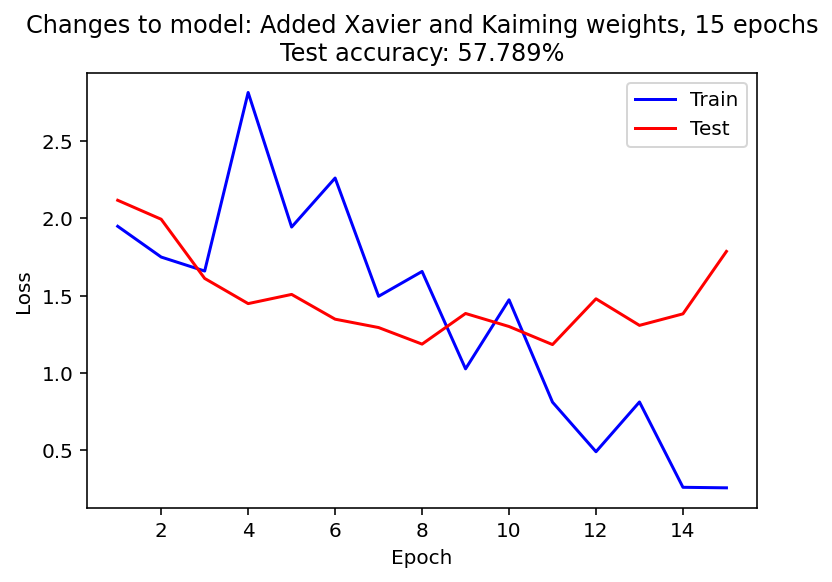

##############################
Epochs: 20
##############################
Epoch : 0 [0/800 (0%)]	Loss: 2.306719	 Accuracy:25.000%
Epoch : 0 [400/800 (50%)]	Loss: 2.387779	 Accuracy:12.745%
Epoch : 1 [0/800 (0%)]	Loss: 1.754906	 Accuracy:62.500%
Epoch : 1 [400/800 (50%)]	Loss: 1.745945	 Accuracy:26.225%
Epoch : 2 [0/800 (0%)]	Loss: 1.746018	 Accuracy:12.500%
Epoch : 2 [400/800 (50%)]	Loss: 2.233027	 Accuracy:30.147%
Epoch : 3 [0/800 (0%)]	Loss: 1.468408	 Accuracy:50.000%
Epoch : 3 [400/800 (50%)]	Loss: 2.274577	 Accuracy:34.804%
Epoch : 4 [0/800 (0%)]	Loss: 1.548603	 Accuracy:37.500%
Epoch : 4 [400/800 (50%)]	Loss: 1.283027	 Accuracy:40.931%
Epoch : 5 [0/800 (0%)]	Loss: 1.528152	 Accuracy:50.000%
Epoch : 5 [400/800 (50%)]	Loss: 1.407033	 Accuracy:47.794%
Epoch : 6 [0/800 (0%)]	Loss: 1.245476	 Accuracy:50.000%
Epoch : 6 [400/800 (50%)]	Loss: 1.615266	 Accuracy:50.000%
Epoch : 7 [0/800 (0%)]	Loss: 1.138901	 Accuracy:37.500%
Epoch : 7 [400/800 (50%)]	Loss: 1.458382	 Accuracy:60.539%
Epoch :

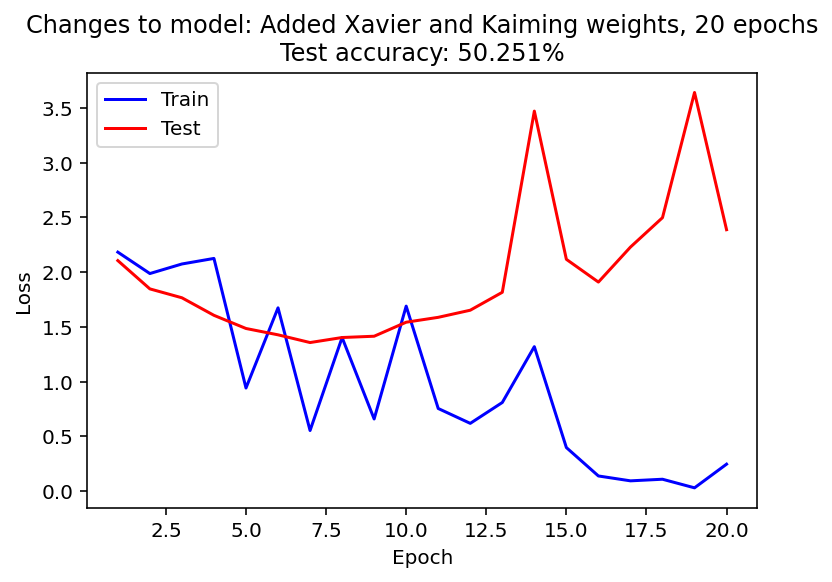

In [35]:
for i in [10, 15, 20]:
  print('#' * 30)
  print(f'Epochs: {i}')
  print('#' * 30)
  net = CNN2().cuda()
  train_loss_history, test_loss_history = train_network(net, i)
  acc = calc_accuracy(net)
  plot_loss(train_loss_history, test_loss_history, acc, f'Added Xavier and Kaiming weights, {i} epochs')

In [24]:
class CNN3(nn.Module):
    def __init__(self,original_model=None):
        super(CNN3, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv3.weight)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv4.weight)
        
        # Linear layers:
        self.fc1 = nn.Linear(4608, 1024)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(1024, 256)
        torch.nn.init.xavier_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(256, 10)
        torch.nn.init.xavier_normal_(self.fc3.weight)

        self.dropout = nn.Dropout()

    def forward(self, x):
      # Convolutional layers:
      x = self.conv1(x)
      x = F.max_pool2d(F.relu(x), 2)
      x = self.conv2(x)
      x = F.max_pool2d(F.relu(x), 2)
      x = self.conv3(x)
      x = F.max_pool2d(F.relu(x), 4)
      x = self.conv4(x)
      x = F.max_pool2d(F.relu(x), 4)

      x = x.view(x.size(0), -1)

      # Linear layers:
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = F.relu(self.fc2(x))
      x = self.dropout(x)
      x = self.fc3(x)
      
      return x

Epoch : 0 [0/800 (0%)]	Loss: 5.351122	 Accuracy:12.500%
Epoch : 0 [400/800 (50%)]	Loss: 2.313736	 Accuracy:12.990%
Epoch : 1 [0/800 (0%)]	Loss: 2.265351	 Accuracy:12.500%
Epoch : 1 [400/800 (50%)]	Loss: 2.472187	 Accuracy:13.480%
Epoch : 2 [0/800 (0%)]	Loss: 2.241381	 Accuracy:12.500%
Epoch : 2 [400/800 (50%)]	Loss: 1.980819	 Accuracy:14.461%
Epoch : 3 [0/800 (0%)]	Loss: 2.441698	 Accuracy:0.000%
Epoch : 3 [400/800 (50%)]	Loss: 2.097533	 Accuracy:22.794%
Epoch : 4 [0/800 (0%)]	Loss: 2.055287	 Accuracy:25.000%
Epoch : 4 [400/800 (50%)]	Loss: 2.167967	 Accuracy:22.304%
Epoch : 5 [0/800 (0%)]	Loss: 1.908120	 Accuracy:37.500%
Epoch : 5 [400/800 (50%)]	Loss: 1.478509	 Accuracy:24.755%
Epoch : 6 [0/800 (0%)]	Loss: 1.698095	 Accuracy:25.000%
Epoch : 6 [400/800 (50%)]	Loss: 1.399332	 Accuracy:36.765%
Epoch : 7 [0/800 (0%)]	Loss: 1.410532	 Accuracy:50.000%
Epoch : 7 [400/800 (50%)]	Loss: 1.743775	 Accuracy:42.157%
Epoch : 8 [0/800 (0%)]	Loss: 1.897544	 Accuracy:50.000%
Epoch : 8 [400/800 (50%)]

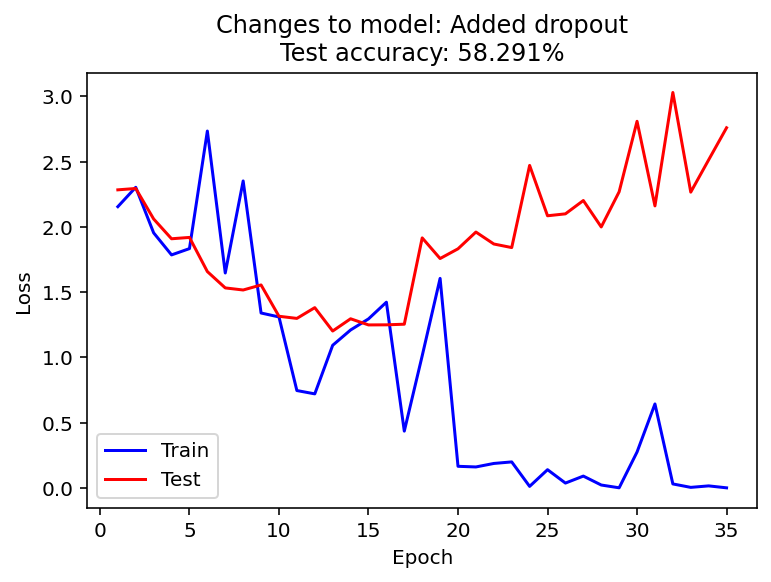

In [25]:
net = CNN3().cuda()
train_loss_history, test_loss_history = train_network(net, 35)
acc = calc_accuracy(net)
plot_loss(train_loss_history, test_loss_history, acc, 'Added dropout')

In [26]:
class CNN4(nn.Module):
    def __init__(self,original_model=None):
        super(CNN4, self).__init__()
        
        # Convolutional layers:
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv3.weight)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv4.weight)
        
        # Linear layers:
        self.fc1 = nn.Linear(4608, 1024)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(1024, 256)
        torch.nn.init.xavier_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(256, 10)
        torch.nn.init.xavier_normal_(self.fc3.weight)

        # Normalizations:
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.batchnorm4 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout()

    def forward(self, x):
      # Convolutional layers:
      x = self.batchnorm1(self.conv1(x))
      x = F.max_pool2d(F.relu(x), 2)
      x = self.batchnorm2(self.conv2(x))
      x = F.max_pool2d(F.relu(x), 2)
      x = self.batchnorm3(self.conv3(x))
      x = F.max_pool2d(F.relu(x), 4)
      x = self.batchnorm4(self.conv4(x))
      x = F.max_pool2d(F.relu(x), 4)

      x = x.view(x.size(0), -1)

      # Linear layers:
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = F.relu(self.fc2(x))
      x = self.dropout(x)
      x = self.fc3(x)
      
      return x

Epoch : 0 [0/800 (0%)]	Loss: 4.751276	 Accuracy:0.000%
Epoch : 0 [400/800 (50%)]	Loss: 2.198840	 Accuracy:8.578%
Epoch : 1 [0/800 (0%)]	Loss: 2.409006	 Accuracy:12.500%
Epoch : 1 [400/800 (50%)]	Loss: 2.211444	 Accuracy:19.608%
Epoch : 2 [0/800 (0%)]	Loss: 1.973330	 Accuracy:37.500%
Epoch : 2 [400/800 (50%)]	Loss: 1.685881	 Accuracy:28.922%
Epoch : 3 [0/800 (0%)]	Loss: 2.303893	 Accuracy:12.500%
Epoch : 3 [400/800 (50%)]	Loss: 1.628342	 Accuracy:32.108%
Epoch : 4 [0/800 (0%)]	Loss: 1.562408	 Accuracy:37.500%
Epoch : 4 [400/800 (50%)]	Loss: 1.478738	 Accuracy:31.863%
Epoch : 5 [0/800 (0%)]	Loss: 1.586773	 Accuracy:37.500%
Epoch : 5 [400/800 (50%)]	Loss: 1.595692	 Accuracy:36.765%
Epoch : 6 [0/800 (0%)]	Loss: 1.604101	 Accuracy:37.500%
Epoch : 6 [400/800 (50%)]	Loss: 1.488997	 Accuracy:43.873%
Epoch : 7 [0/800 (0%)]	Loss: 1.479090	 Accuracy:12.500%
Epoch : 7 [400/800 (50%)]	Loss: 1.470519	 Accuracy:43.627%
Epoch : 8 [0/800 (0%)]	Loss: 1.513553	 Accuracy:37.500%
Epoch : 8 [400/800 (50%)]	

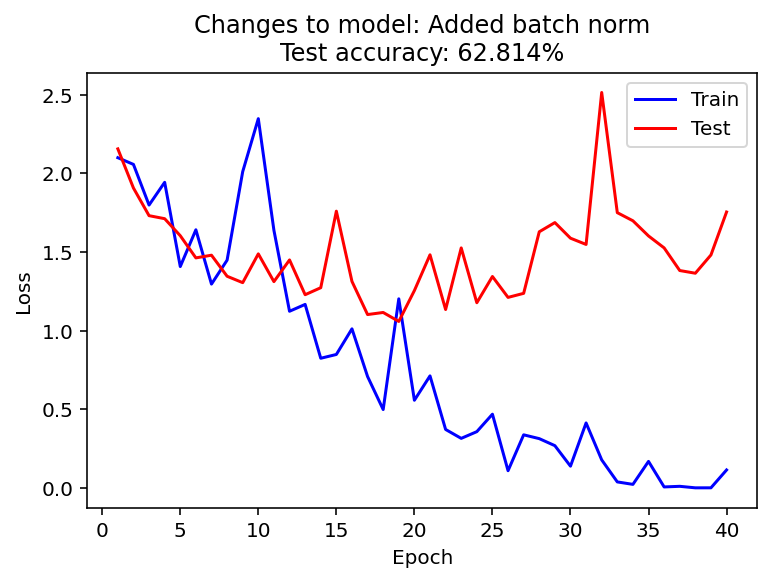

In [27]:
net = CNN4().cuda()
train_loss_history, test_loss_history = train_network(net, 40)
acc = calc_accuracy(net)
plot_loss(train_loss_history, test_loss_history, acc, 'Added batch norm')

In [28]:
class CNN_FINAL(nn.Module):
    def __init__(self,original_model=None):
        super(CNN_FINAL, self).__init__()
        
        # Convolutional layers:
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv3.weight)
        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)
        torch.nn.init.kaiming_uniform_(self.conv4.weight)
        
        # Linear layers:
        self.fc1 = nn.Linear(4608, 1024)
        torch.nn.init.xavier_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(1024, 256)
        torch.nn.init.xavier_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(256, 10)
        torch.nn.init.xavier_normal_(self.fc3.weight)

        # Normalizations:
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.batchnorm2 = nn.BatchNorm2d(128)
        self.batchnorm3 = nn.BatchNorm2d(256)
        self.batchnorm4 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout()

    def forward(self, x):
      # Convolutional layers:
      x = self.batchnorm1(self.conv1(x))
      x = F.max_pool2d(F.relu(x), 2)
      x = self.batchnorm2(self.conv2(x))
      x = F.max_pool2d(F.relu(x), 2)
      x = self.batchnorm3(self.conv3(x))
      x = F.max_pool2d(F.relu(x), 4)
      x = self.batchnorm4(self.conv4(x))
      x = F.max_pool2d(F.relu(x), 4)

      x = x.view(x.size(0), -1)

      # Linear layers:
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = F.relu(self.fc2(x))
      x = self.dropout(x)
      x = self.fc3(x)
      
      return F.log_softmax(x, dim=1)

##############################
Epochs: 30
##############################
Epoch : 0 [0/800 (0%)]	Loss: 5.920579	 Accuracy:25.000%
Epoch : 0 [400/800 (50%)]	Loss: 2.750393	 Accuracy:13.235%
Epoch : 1 [0/800 (0%)]	Loss: 2.260887	 Accuracy:25.000%
Epoch : 1 [400/800 (50%)]	Loss: 2.066323	 Accuracy:19.853%
Epoch : 2 [0/800 (0%)]	Loss: 2.228764	 Accuracy:25.000%
Epoch : 2 [400/800 (50%)]	Loss: 1.837996	 Accuracy:24.020%
Epoch : 3 [0/800 (0%)]	Loss: 2.251338	 Accuracy:12.500%
Epoch : 3 [400/800 (50%)]	Loss: 2.124943	 Accuracy:24.510%
Epoch : 4 [0/800 (0%)]	Loss: 1.360695	 Accuracy:37.500%
Epoch : 4 [400/800 (50%)]	Loss: 1.942894	 Accuracy:31.863%
Epoch : 5 [0/800 (0%)]	Loss: 1.649937	 Accuracy:25.000%
Epoch : 5 [400/800 (50%)]	Loss: 2.355443	 Accuracy:31.127%
Epoch : 6 [0/800 (0%)]	Loss: 2.185030	 Accuracy:25.000%
Epoch : 6 [400/800 (50%)]	Loss: 1.019198	 Accuracy:37.255%
Epoch : 7 [0/800 (0%)]	Loss: 1.205657	 Accuracy:62.500%
Epoch : 7 [400/800 (50%)]	Loss: 2.413393	 Accuracy:46.078%
Epoch :

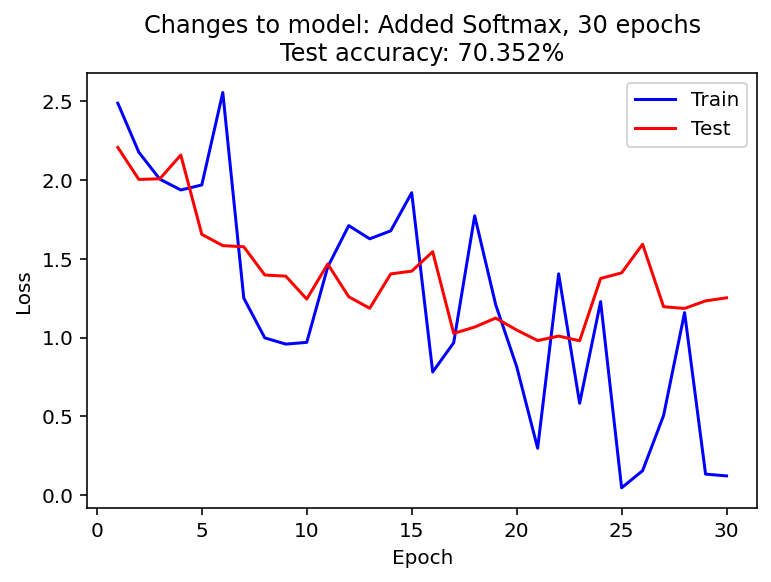

##############################
Epochs: 40
##############################
Epoch : 0 [0/800 (0%)]	Loss: 4.535926	 Accuracy:25.000%
Epoch : 0 [400/800 (50%)]	Loss: 2.355900	 Accuracy:10.784%
Epoch : 1 [0/800 (0%)]	Loss: 2.539108	 Accuracy:0.000%
Epoch : 1 [400/800 (50%)]	Loss: 2.252252	 Accuracy:16.912%
Epoch : 2 [0/800 (0%)]	Loss: 2.078023	 Accuracy:37.500%
Epoch : 2 [400/800 (50%)]	Loss: 1.360850	 Accuracy:29.902%
Epoch : 3 [0/800 (0%)]	Loss: 2.027139	 Accuracy:37.500%
Epoch : 3 [400/800 (50%)]	Loss: 2.197212	 Accuracy:27.941%
Epoch : 4 [0/800 (0%)]	Loss: 2.156342	 Accuracy:37.500%
Epoch : 4 [400/800 (50%)]	Loss: 1.918962	 Accuracy:34.559%
Epoch : 5 [0/800 (0%)]	Loss: 1.457924	 Accuracy:50.000%
Epoch : 5 [400/800 (50%)]	Loss: 1.302856	 Accuracy:37.255%
Epoch : 6 [0/800 (0%)]	Loss: 1.872197	 Accuracy:62.500%
Epoch : 6 [400/800 (50%)]	Loss: 1.274223	 Accuracy:43.382%
Epoch : 7 [0/800 (0%)]	Loss: 1.972975	 Accuracy:25.000%
Epoch : 7 [400/800 (50%)]	Loss: 1.700969	 Accuracy:41.176%
Epoch : 

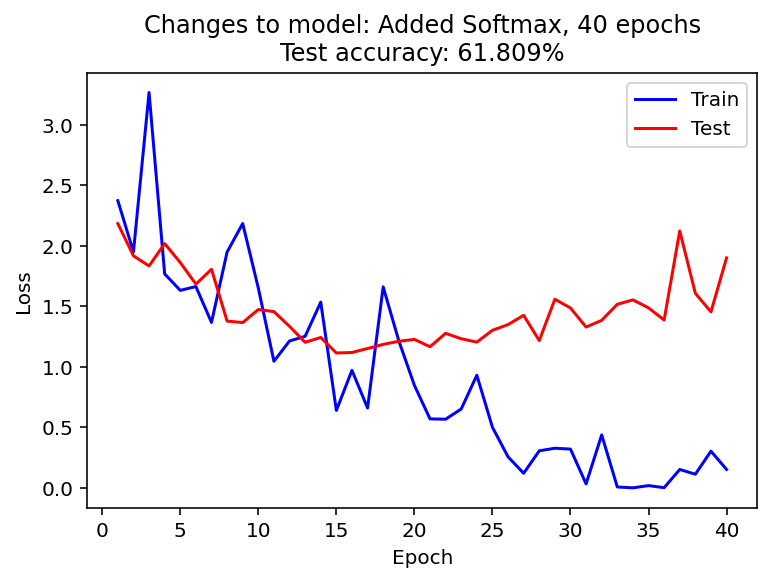

##############################
Epochs: 50
##############################
Epoch : 0 [0/800 (0%)]	Loss: 5.971103	 Accuracy:0.000%
Epoch : 0 [400/800 (50%)]	Loss: 2.116715	 Accuracy:9.559%
Epoch : 1 [0/800 (0%)]	Loss: 2.199241	 Accuracy:12.500%
Epoch : 1 [400/800 (50%)]	Loss: 2.165753	 Accuracy:17.402%
Epoch : 2 [0/800 (0%)]	Loss: 2.145146	 Accuracy:12.500%
Epoch : 2 [400/800 (50%)]	Loss: 2.280182	 Accuracy:24.755%
Epoch : 3 [0/800 (0%)]	Loss: 1.635056	 Accuracy:37.500%
Epoch : 3 [400/800 (50%)]	Loss: 1.755349	 Accuracy:31.373%
Epoch : 4 [0/800 (0%)]	Loss: 1.532512	 Accuracy:37.500%
Epoch : 4 [400/800 (50%)]	Loss: 2.572815	 Accuracy:30.147%
Epoch : 5 [0/800 (0%)]	Loss: 2.107848	 Accuracy:12.500%
Epoch : 5 [400/800 (50%)]	Loss: 1.126728	 Accuracy:42.402%
Epoch : 6 [0/800 (0%)]	Loss: 1.699018	 Accuracy:25.000%
Epoch : 6 [400/800 (50%)]	Loss: 1.336806	 Accuracy:40.931%
Epoch : 7 [0/800 (0%)]	Loss: 2.022988	 Accuracy:25.000%
Epoch : 7 [400/800 (50%)]	Loss: 0.948214	 Accuracy:44.118%
Epoch : 8

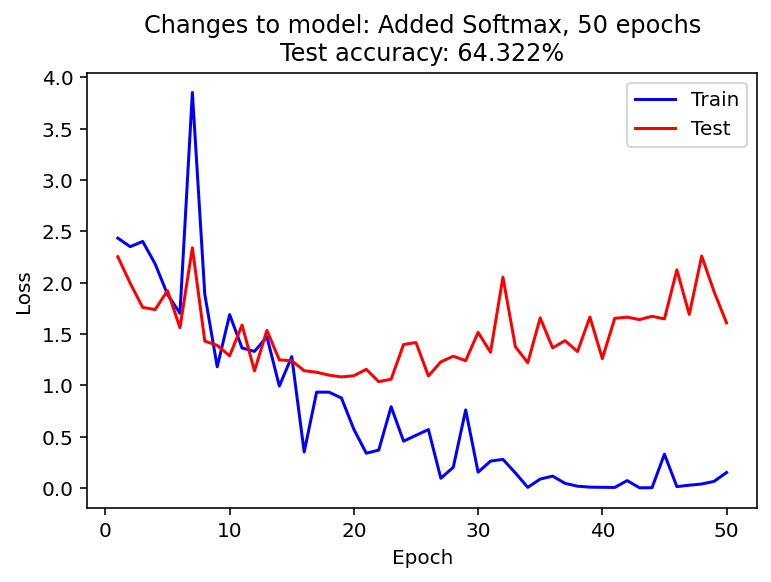

##############################
Epochs: 60
##############################
Epoch : 0 [0/800 (0%)]	Loss: 6.002694	 Accuracy:0.000%
Epoch : 0 [400/800 (50%)]	Loss: 2.360372	 Accuracy:8.824%
Epoch : 1 [0/800 (0%)]	Loss: 2.230489	 Accuracy:12.500%
Epoch : 1 [400/800 (50%)]	Loss: 2.500976	 Accuracy:22.794%
Epoch : 2 [0/800 (0%)]	Loss: 2.019290	 Accuracy:25.000%
Epoch : 2 [400/800 (50%)]	Loss: 1.821305	 Accuracy:22.549%
Epoch : 3 [0/800 (0%)]	Loss: 2.646688	 Accuracy:0.000%
Epoch : 3 [400/800 (50%)]	Loss: 1.718224	 Accuracy:28.186%
Epoch : 4 [0/800 (0%)]	Loss: 1.888974	 Accuracy:25.000%
Epoch : 4 [400/800 (50%)]	Loss: 1.722281	 Accuracy:31.863%
Epoch : 5 [0/800 (0%)]	Loss: 1.999779	 Accuracy:37.500%
Epoch : 5 [400/800 (50%)]	Loss: 1.375032	 Accuracy:36.275%
Epoch : 6 [0/800 (0%)]	Loss: 1.195707	 Accuracy:37.500%
Epoch : 6 [400/800 (50%)]	Loss: 1.381563	 Accuracy:41.912%
Epoch : 7 [0/800 (0%)]	Loss: 2.117518	 Accuracy:25.000%
Epoch : 7 [400/800 (50%)]	Loss: 0.862813	 Accuracy:45.098%
Epoch : 8 

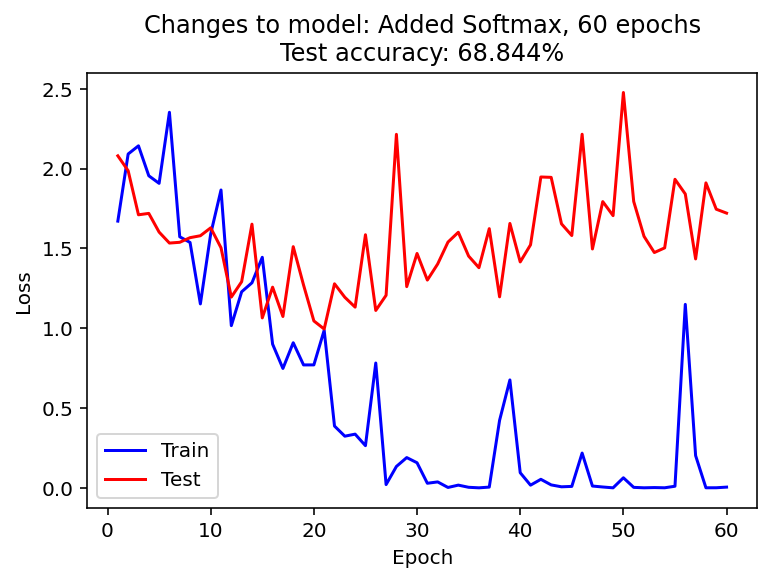

In [29]:
for i in [30, 40, 50, 60]:
  print('#' * 30)
  print(f'Epochs: {i}')
  print('#' * 30)
  net = CNN_FINAL().cuda()
  train_loss_history, test_loss_history = train_network(net, i)
  acc = calc_accuracy(net)
  plot_loss(train_loss_history, test_loss_history, acc, f'Added Softmax, {i} epochs')